# MCMC with Blackjax for Sparse Regression

Following the example in sparse_regression.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
import blackjax

tfd = tfp.distributions
jdc = tfp.distributions.JointDistributionCoroutineAutoBatched

rng = jax.random.PRNGKey(20230515)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Data Generation

In [3]:
M, N, alpha0, sigma0, sig_prob0 = 200, 100, 3.0, 1.0, 0.05

rng, key0, key1, key2, key3, key4, key5 = jax.random.split(rng, 7)
X = jax.random.normal(key0, (N, M))
beta0 = jax.random.normal(key1, (M,)) * 0.25
index = jax.random.uniform(key2, (M,)) <= 0.05
beta_replace = jax.random.normal(key3, (index.sum(),)) + 10 * jax.random.choice(
    key4, np.asarray([-1, 1]), (index.sum(),)
)
beta0 = beta0.at[index].set(beta_replace)
y = X @ beta0 + alpha0 + jax.random.normal(key5, (N,)) * sigma0


Text(0.5, 0, 'True Slopes')

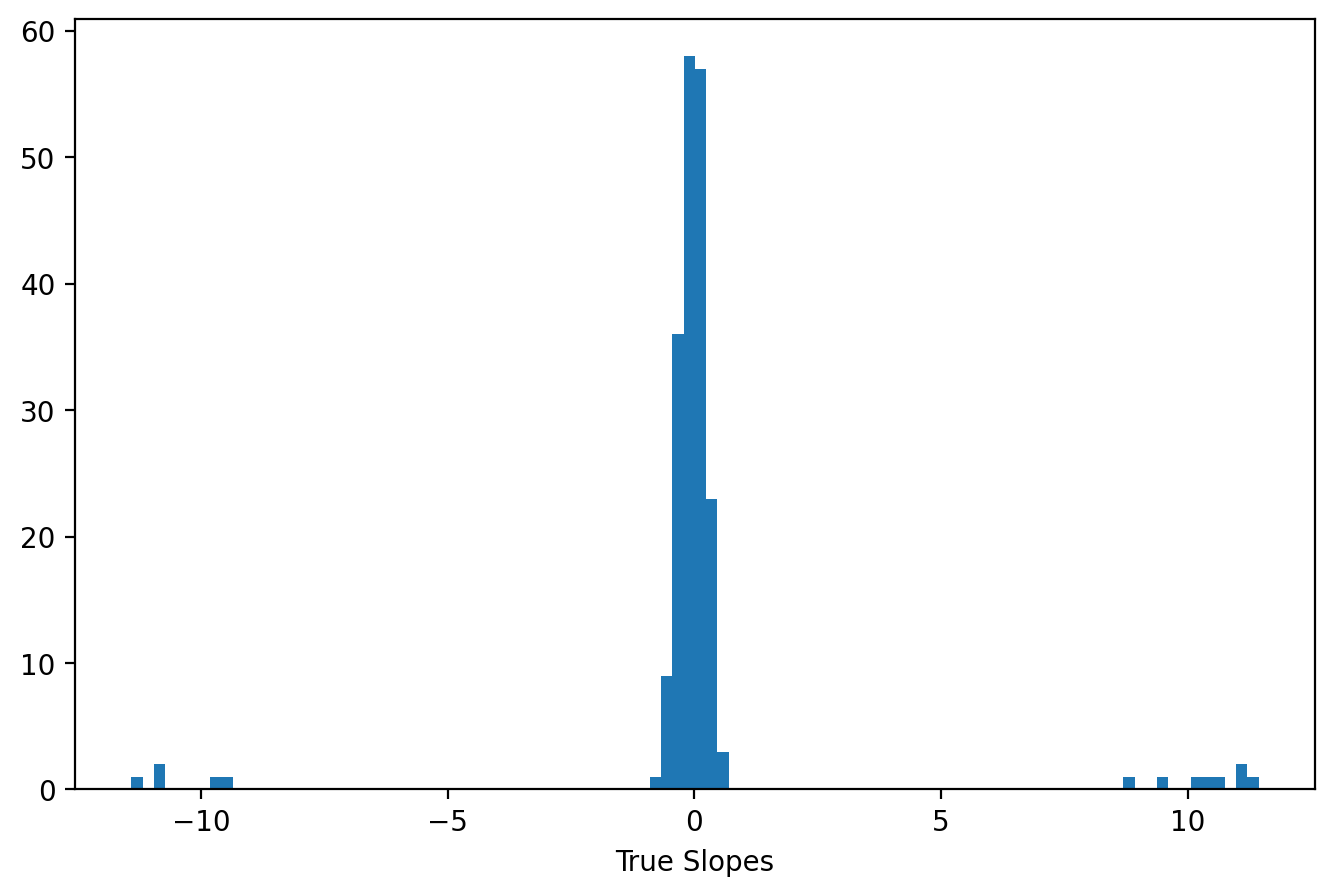

In [4]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(beta0, 100)
ax.set_xlabel("True Slopes")


## Model generation function

In [5]:
def get_joint_logdensity(pinned_model):
    # Get the default change of variable bijectors from the model
    bijectors = pinned_model.experimental_default_event_space_bijector()

    def joint_logdensity(unbound_param):
        param = bijectors.forward(unbound_param)
        log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
        return pinned_model.unnormalized_log_prob(param) + log_det_jacobian

    return joint_logdensity, bijectors


In [6]:
def regression_model(design_matrix, beta_dist=tfd.Normal, **beta_kwargs):
    @jdc
    def model():
        intercept = yield tfd.Normal(0.0, 2.0, name="intercept")
        sigma = yield tfd.HalfNormal(2.0, name="sigma")
        beta = yield tfd.Sample(beta_dist(**beta_kwargs), M, name="beta")
        yhat = design_matrix @ beta + intercept
        yield tfd.Normal(yhat, sigma, name="y")

    return model


In [7]:
# wide_normal_model = regression_model(X, tfd.Normal, loc=0.0, scale=10.0)
# narrow_normal_model = regression_model(X, tfd.Normal, loc=0.0, scale=1.0)

# laplace_model = regression_model(X, tfd.Laplace, loc=0.0, scale=1.0)


## Inference util

In [8]:
def inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, log_prob_fn, num_samples, num_chains
):
    step_fn = blackjax.nuts.build_kernel()

    def kernel(key, state, **params):
        return step_fn(key, state, log_prob_fn, **params)

    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states, **tuned_params)
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)


In [9]:
def run_warmpup(
    logdensity_fn, warmup_key, init_params, n_warmup=1000, n_chains=4,
    is_mass_matrix_diagonal=True,
):

    warmup = blackjax.window_adaptation(blackjax.nuts, logdensity_fn, is_mass_matrix_diagonal)

    @jax.vmap
    def call_warmup(seed, param):
        (initial_states, tuned_params), _ = warmup.run(seed, param, n_warmup)
        return initial_states, tuned_params

    keys = jax.random.split(warmup_key, n_chains)
    initial_states, tuned_params = call_warmup(keys, init_params)
    return initial_states, tuned_params

def run_warmpup_and_inference(
    logdensity_fn, seed, init_params, n_warmup=1000, n_samples=1000, n_chains=4
):
    sample_key, warmup_key = jax.random.split(seed, 2)
    initial_states, tuned_params = run_warmpup(
        logdensity_fn, warmup_key, init_params, n_warmup, n_chains)
    return inference_loop_multiple_chains(
        sample_key, initial_states, tuned_params, logdensity_fn, n_samples, n_chains
    )


In [10]:
def display_diagnostics(posterior_samples):
    ess = jax.tree_map(
        lambda x: blackjax.diagnostics.effective_sample_size(x, 1, 0), posterior_samples
    )
    rhat = jax.tree_map(
        lambda x: blackjax.diagnostics.potential_scale_reduction(x, 1, 0),
        posterior_samples,
    )
    _, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    ax[0].plot(jax.flatten_util.ravel_pytree(rhat)[0])
    ax[0].hlines(1.1, *ax[0].get_xlim(), linestyle="--", alpha=0.5)
    ax[0].set_title("Rhat")
    ax[1].plot(jax.flatten_util.ravel_pytree(ess)[0])
    ax[1].hlines(
        np.prod(jax.tree_util.tree_flatten(posterior_samples)[0][0].shape[:2]),
        *ax[0].get_xlim(),
        linestyle="--",
        alpha=0.5
    )
    ax[1].set_title("ESS")


## Model that is difficult to sample with standard routine (window adaptation NUTS)

In [11]:
horseshoe_model = regression_model(X, tfd.Horseshoe, scale=1.0)

pinned_model_horseshoe = horseshoe_model.experimental_pin(y=y)
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model_horseshoe.sample_unpinned(4, seed=init_key)
joint_logdensity, bijectors = get_joint_logdensity(pinned_model_horseshoe)

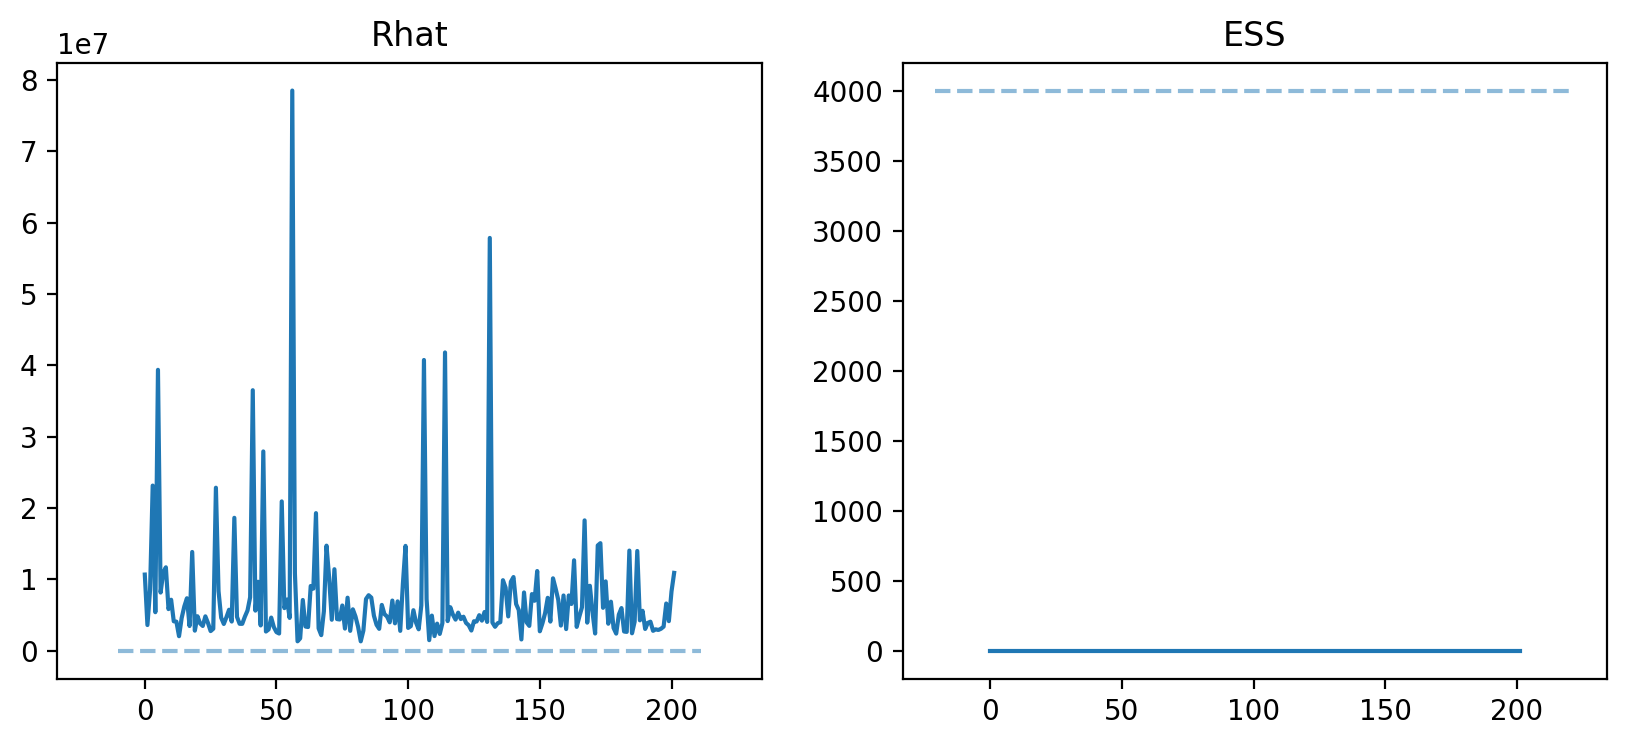

In [12]:
states_horseshoe, infos = run_warmpup_and_inference(
    joint_logdensity, sample_key, bijectors.inverse(init_params),
)

posterior_horseshoe = bijectors.forward(states_horseshoe.position)
display_diagnostics(posterior_horseshoe)

## Composable Inference in Blackjax

Breaking down window adaptation

In [13]:
init_params = pinned_model_horseshoe.sample_unpinned(seed=init_key)

Explore the effect of using different step size

In [14]:
from functools import partial
from jax.flatten_util import ravel_pytree

# Initialize the state
state = blackjax.mcmc.nuts.init(init_params, joint_logdensity)
# Low level NUTS API
nuts_onestep_ = blackjax.mcmc.nuts.build_kernel()
nuts_onestep = jax.jit(partial(nuts_onestep_, logdensity_fn=joint_logdensity))
tuneable_params = dict(
    step_size=1e-3, inverse_mass_matrix=jnp.ones_like(ravel_pytree(init_params)[0])
)
# one iteration of NUTS sampler
next_state, info = nuts_onestep(sample_key, state, **tuneable_params)


Understand the output and their shape

In [15]:
jax.tree_map(jnp.shape, state)


HMCState(position=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), logdensity=(), logdensity_grad=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
))

In [16]:
jax.tree_map(jnp.shape, info)


NUTSInfo(momentum=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), is_divergent=(), is_turning=(), energy=(), trajectory_leftmost_state=IntegratorState(position=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), momentum=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), logdensity=(), logdensity_grad=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
)), trajectory_rightmost_state=IntegratorState(position=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), momentum=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
), logdensity=(), logdensity_grad=StructTuple(
  intercept=(),
  sigma=(),
  beta=(200,)
)), num_trajectory_expansions=(), num_integration_steps=(), acceptance_rate=())

(-0.0025, 0.0025)

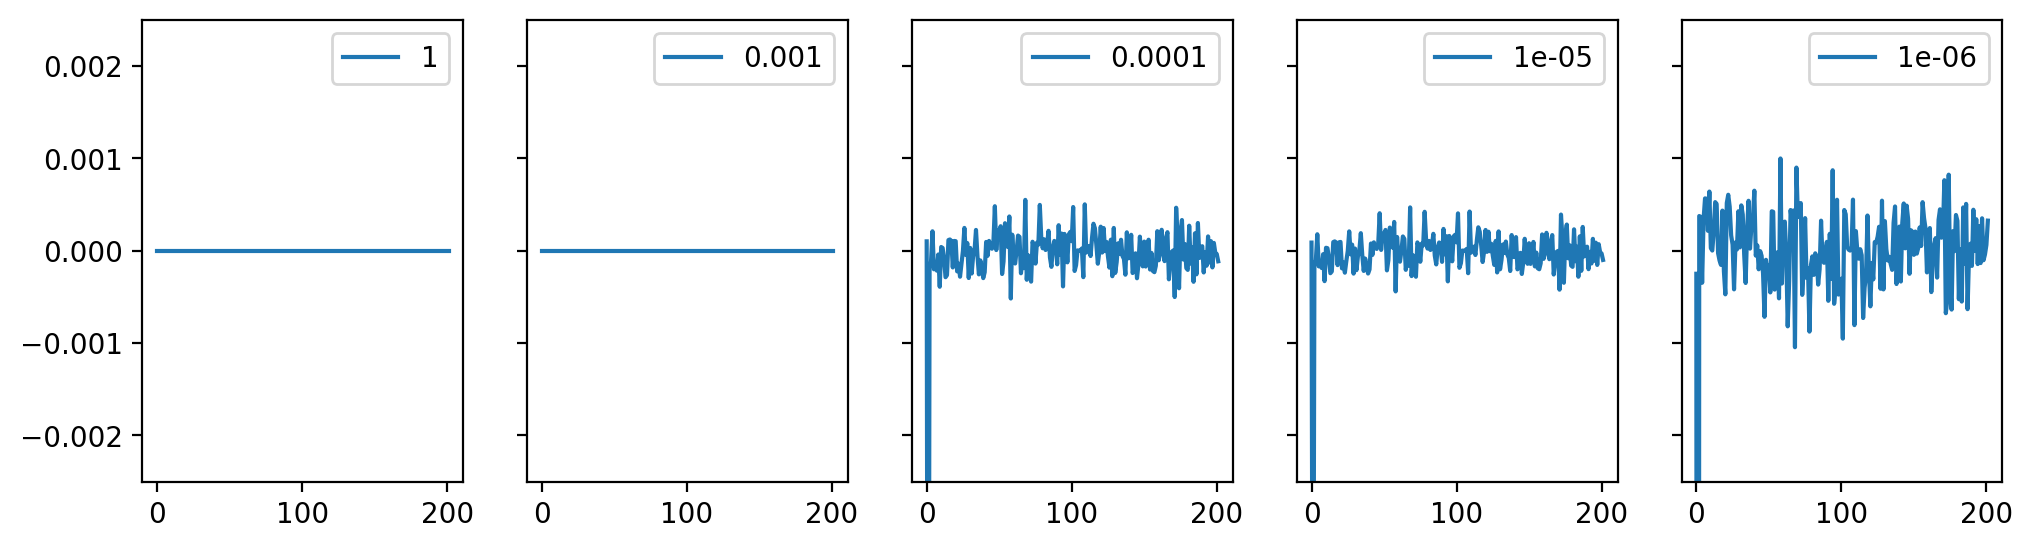

In [17]:
_, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True)
for (step_size, ax) in zip([1, 1e-3, 1e-4, 1e-5, 1e-6], axes):
    tuneable_params["step_size"] = step_size
    next_state, info = nuts_onestep(sample_key, state, **tuneable_params)

    flatten_state0 = ravel_pytree(state.position)[0]
    flatten_state1 = ravel_pytree(next_state.position)[0]
    ax.plot(flatten_state0 - flatten_state1, label=step_size)
    ax.legend()
ax.set_ylim(-0.0025, 0.0025)


Investigate the behavior of the step size adaptation

In [18]:
from blackjax.adaptation.step_size import dual_averaging_adaptation

da_init, da_update, da_final = dual_averaging_adaptation(target=0.8)
da_state = da_init(inital_step_size=1.0)


In [19]:
step_size_hist = [jnp.exp(da_state.log_step_size)]

for i in range(100):
    rng, sample_key = jax.random.split(rng)
    # Sampling
    tuneable_params["step_size"] = jnp.exp(da_state.log_step_size)
    state, info = nuts_onestep(sample_key, state, **tuneable_params)
    # Tuning
    da_state = jax.jit(da_update)(da_state, info.acceptance_rate)
    # Logging
    step_size_hist.append(jnp.exp(da_state.log_step_size))


0.007630723


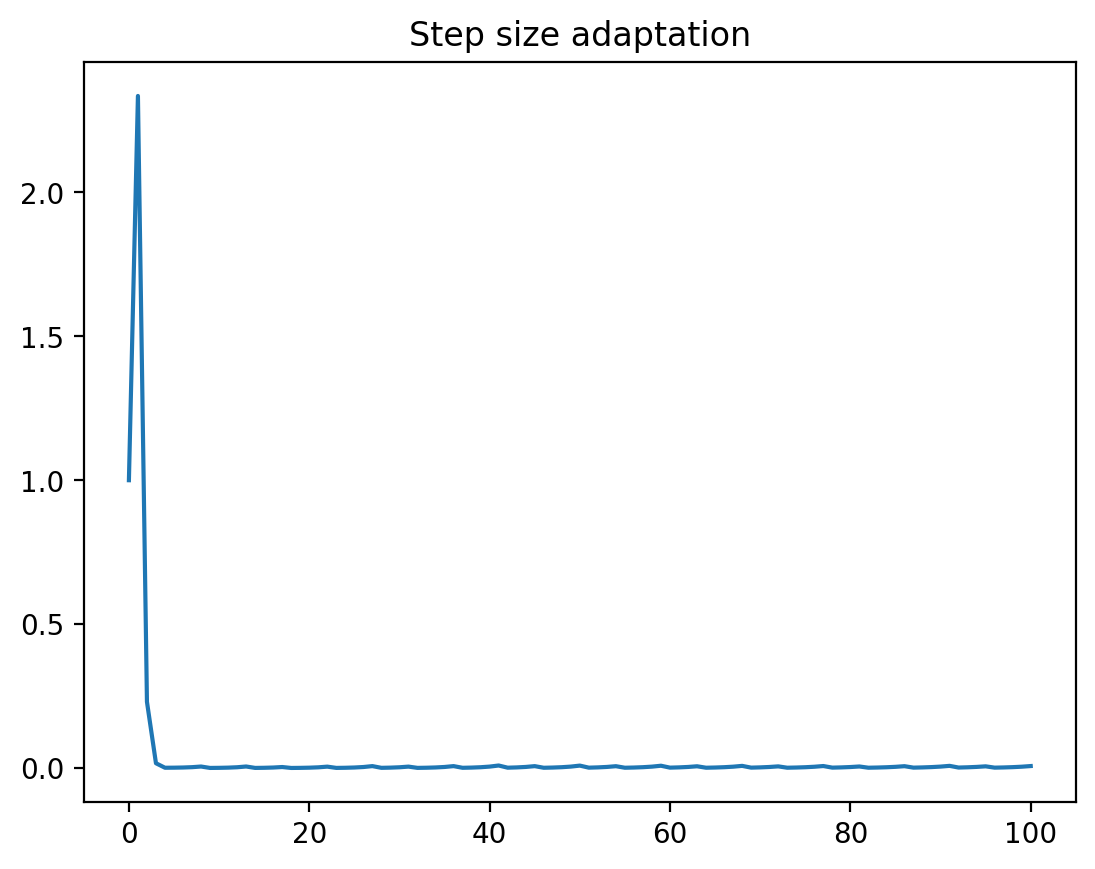

In [20]:
plt.plot(step_size_hist)
plt.title("Step size adaptation")
print(np.mean(step_size_hist[-10]))


Text(0.5, 1.0, 'Change in beta between initial and after step size adaptation')

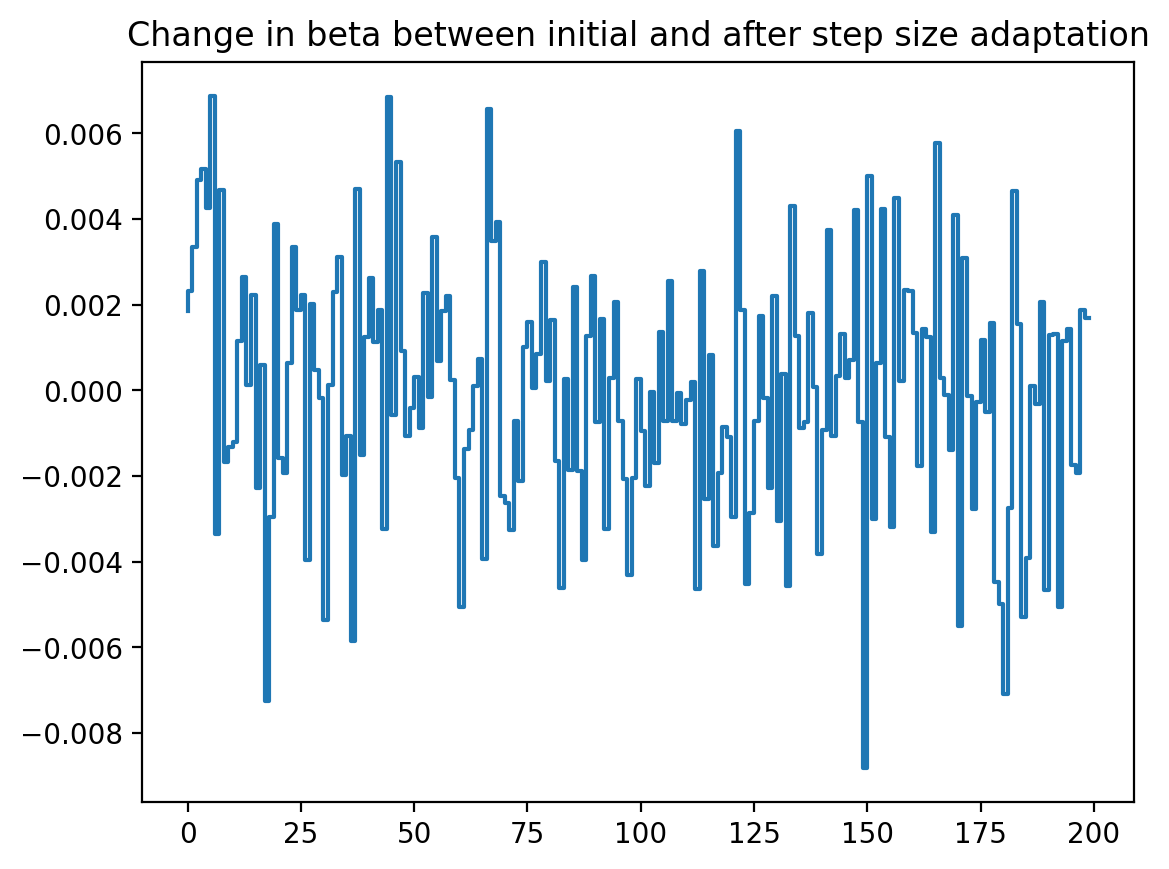

In [21]:
plt.step(np.arange(M), init_params.beta - state.position.beta)
plt.title("Change in beta between initial and after step size adaptation")
# plt.step(np.arange(M), beta0, color='r')


The step size adapted to a small value very quickly, but since the step size is so small the chain will move very slowly - this is then bad for mass matrix adaptation. The mass matrix adaptation is then not able to adapt to the correct value quickly enough and the chain gets stuck in a bad region.

One idea is to initialized the mass matrix with the proper scaling in `beta` (in the iterative model building process we can use the posterior from a different model e.g., Laplace prior). This is not implemented in BlackJax for high level API yet but it is possible to do it using the low level API.

## Better mass matrix initialization

Using the posterior variance from Laplace prior as the initial mass matrix

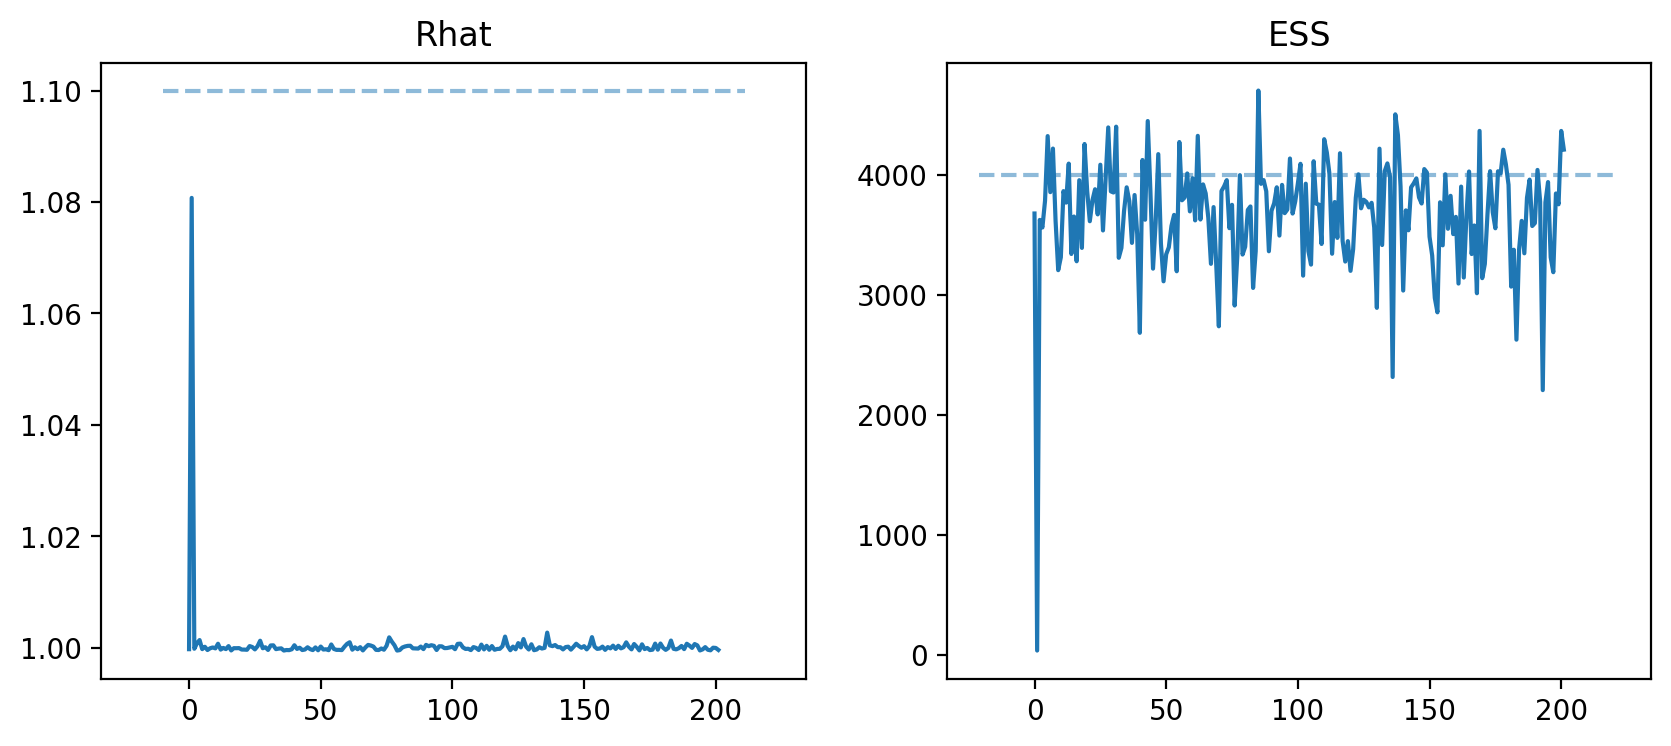

In [22]:
laplace_model = regression_model(X, tfd.Laplace, loc=0.0, scale=1.0)

pinned_model_laplace = laplace_model.experimental_pin(y=y)
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model_laplace.sample_unpinned(4, seed=init_key)
joint_logdensity_laplace, bijectors = get_joint_logdensity(pinned_model_laplace)

# states_laplace, infos = run_warmpup_and_inference(
#     joint_logdensity, sample_key, bijectors.inverse(init_params),
# )
sample_key, warmup_key = jax.random.split(sample_key, 2)
initial_states, tuned_params = run_warmpup(
    joint_logdensity_laplace, warmup_key, init_params, 1000, n_chains=4,
    is_mass_matrix_diagonal=False)
states_laplace, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params, joint_logdensity_laplace, 1000, num_chains=4
)

posterior_laplace = bijectors.forward(states_laplace.position)
display_diagnostics(posterior_laplace)

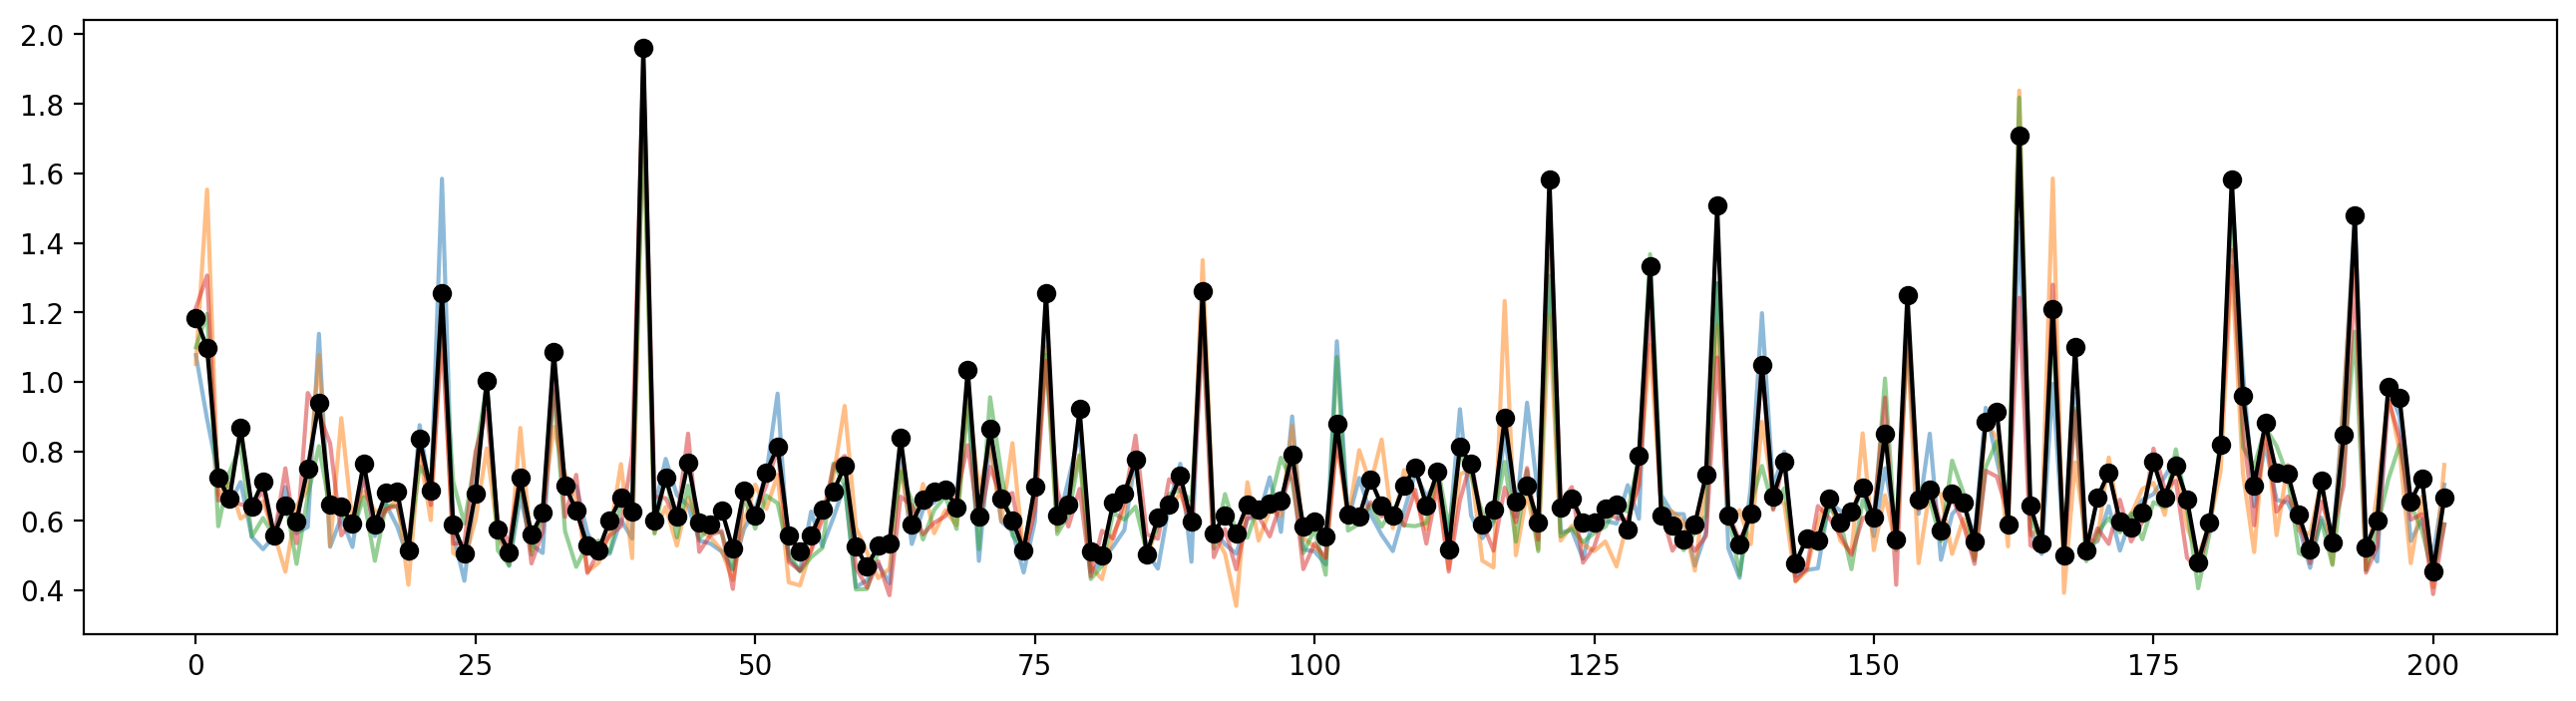

In [23]:
posterior_var = ravel_pytree(
    jax.tree_map(
        lambda x: jnp.var(x, axis=[0, 1]), 
        states_laplace.position)
    )[0]
posterior_mean = jax.tree_map(
        lambda x: jnp.mean(x, axis=[0, 1]),
        states_laplace.position)
_, ax = plt.subplots(figsize=(16, 4))
if np.ndim(tuned_params["inverse_mass_matrix"]) == 2:
    ax.plot(tuned_params["inverse_mass_matrix"].T, alpha=.5)
else:
    ax.plot(jax.vmap(jnp.diag)(tuned_params["inverse_mass_matrix"]).T, alpha=.5)
ax.plot(posterior_var, color="k", marker="o");

In [24]:
da_init, da_update, da_final = dual_averaging_adaptation(target=0.8)
da_state = da_init(
    inital_step_size=tuned_params["step_size"].mean()
    )
step_size_hist = [jnp.exp(da_state.log_step_size)]

# tuneable_params["inverse_mass_matrix"] = posterior_var
# init_params = posterior_mean
tuneable_params["inverse_mass_matrix"] = jnp.mean(tuned_params["inverse_mass_matrix"], axis=[0])
init_params = jax.tree_map(
        lambda x: jnp.mean(x, axis=[0]), 
        initial_states.position)

# init_params = pinned_model_horseshoe.sample_unpinned(seed=init_key)
state = blackjax.mcmc.nuts.init(init_params, joint_logdensity)

for i in range(200):
    rng, sample_key = jax.random.split(rng)
    # Sampling
    tuneable_params["step_size"] = jnp.exp(da_state.log_step_size)
    state, info = nuts_onestep(sample_key, state, **tuneable_params)
    # Tuning
    da_state = jax.jit(da_update)(da_state, info.acceptance_rate)
    # Logging
    step_size_hist.append(jnp.exp(da_state.log_step_size))


4.4374533e-06


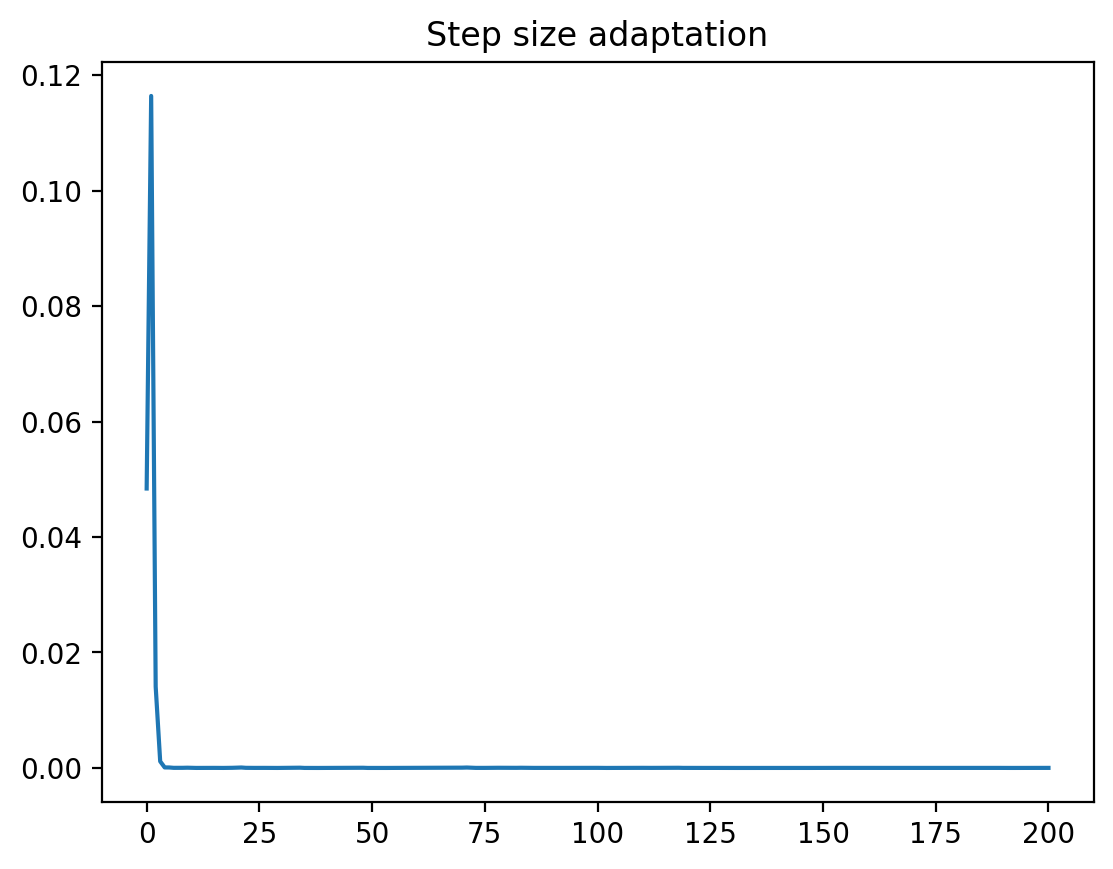

In [25]:
plt.plot(step_size_hist)
plt.title("Step size adaptation")
print(np.mean(step_size_hist[-10]))


Text(0.5, 1.0, 'Change in beta between initial and after step size adaptation')

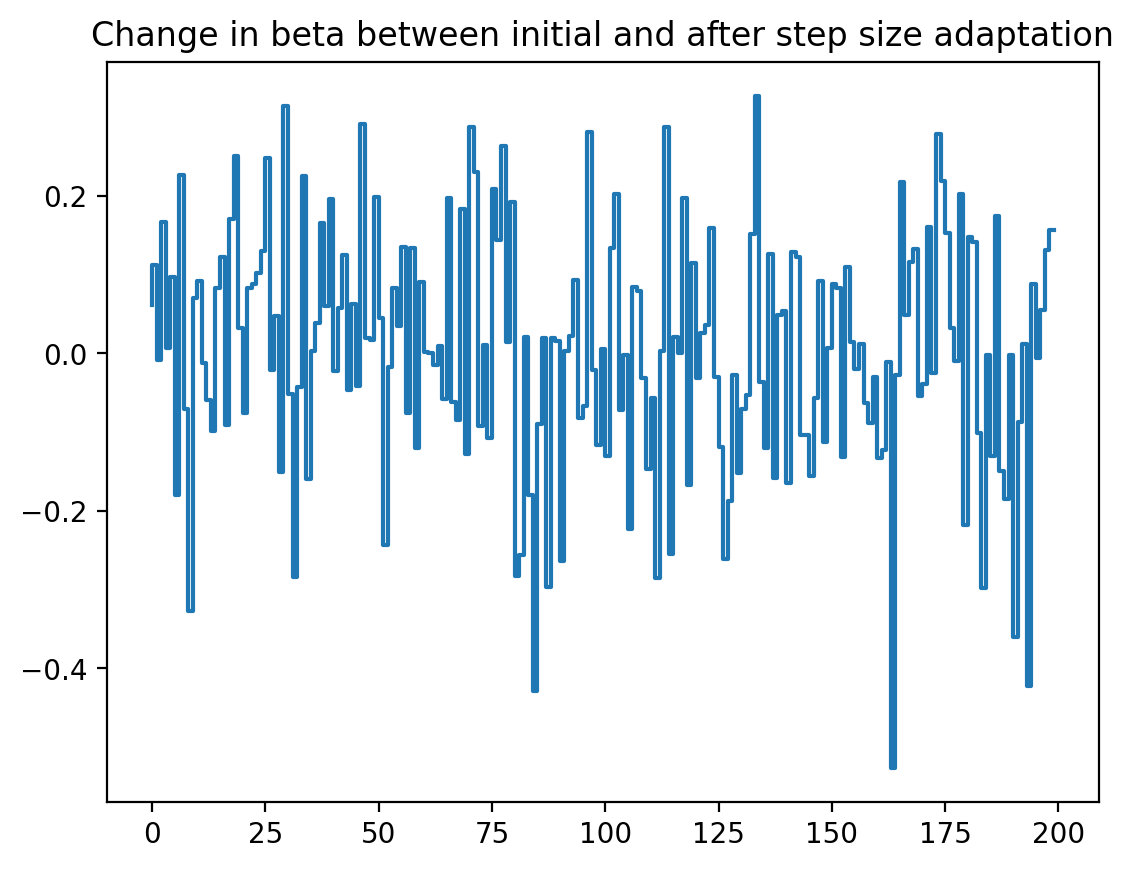

In [26]:
plt.step(np.arange(M), init_params.beta - state.position.beta)
plt.title("Change in beta between initial and after step size adaptation")
# plt.step(np.arange(M), state.position.beta, color='r')

The state change is much larger and pretty uniform across parameters (both the sparse/large coefficient and the small coefficient), let's try to sample again with the same mass matrix and tuned step size.

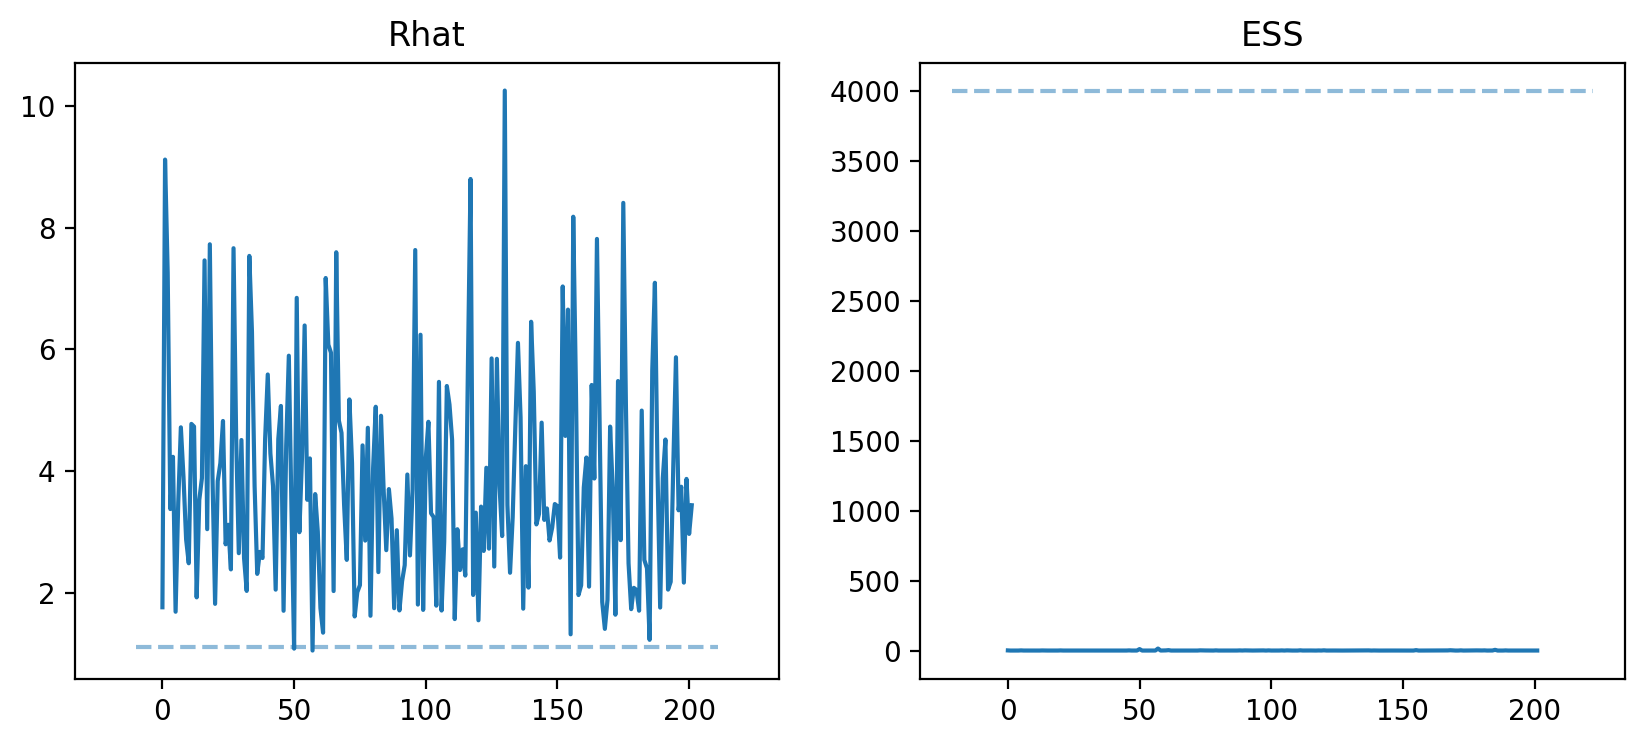

In [27]:
joint_logdensity, bijectors = get_joint_logdensity(pinned_model_horseshoe)

tuned_params_new = dict(
    # step_size=np.mean(step_size_hist[-10]),
    step_size=tuned_params["step_size"].mean(),
    inverse_mass_matrix=tuneable_params["inverse_mass_matrix"]
)
tuned_params_new = jax.tree_map(lambda x: jnp.repeat(x[None, ...], 4, axis=0), tuned_params_new)

states_horseshoe, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params_new, joint_logdensity, 1000, num_chains=4
)

posterior_horseshoe = bijectors.forward(states_horseshoe.position)
display_diagnostics(posterior_horseshoe)

In [28]:
infos.num_integration_steps

Array([[ 26,   1,  43, 127],
       [ 25,  63,  51,  27],
       [  2, 128,  11,  17],
       ...,
       [ 78,   7, 127,  37],
       [  6,  36,  31,  32],
       [ 27,  23,  42,  28]], dtype=int32, weak_type=True)

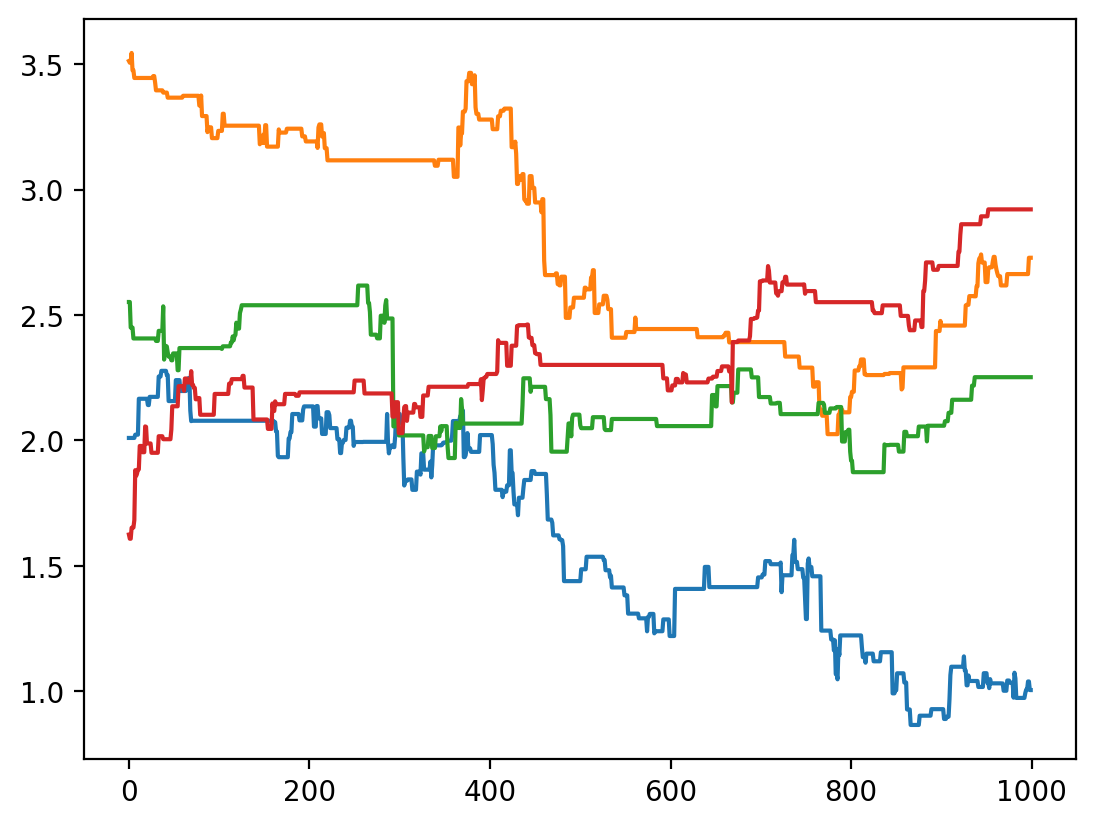

In [29]:
plt.plot(posterior_horseshoe.intercept);

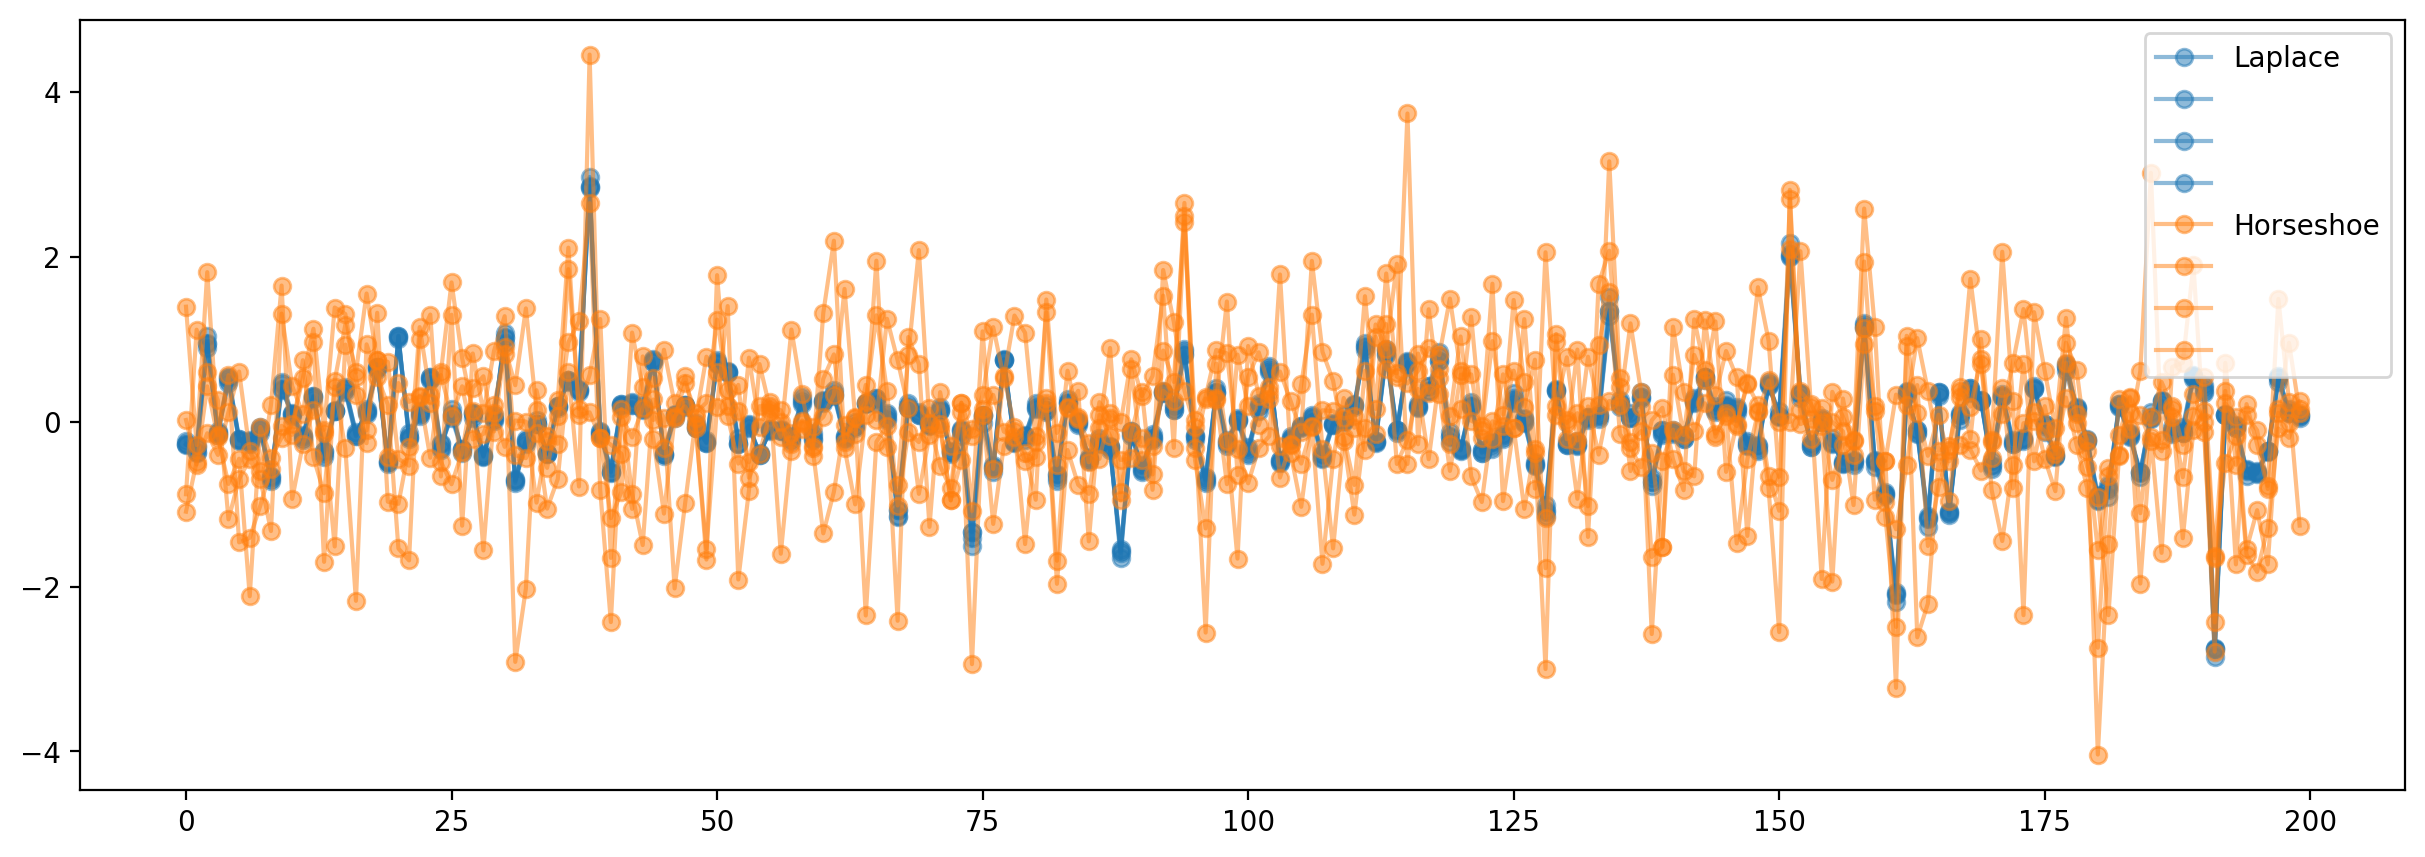

In [30]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
for i, beta_mcmc in enumerate([
    posterior_laplace.beta, 
    posterior_horseshoe.beta]):
    ax.plot(
        np.arange(M),
        beta_mcmc.mean(axis=[0]).T - beta0[..., None],
        marker="o", alpha=0.5, color=f"C{i}"
    )
ax.legend(["Laplace", "", "", "", "Horseshoe", "", "", ""]);

## Summary

`Blackjax` API signature

```python
# Signature of MCMC kernel one step function
def mcmc_kernel_onestep(
        random_key, sampler_state: State, **tuneable_params
        ) -> (State, SamplerInfo):

# Signature of MCMC parameter tuning function
def tuning_onestep(
        tuning_state: TuningState, sampler_info: SamplerInfo
        ) -> (TuningState, TuningInfo):

# Signature of MCMC with tuning
for ...:
    # Sampling
    sampler_state, sampler_info = mcmc_kernel_onestep(...)
    # Tuning
    tuning_state, tuning_info = tuning_onestep(...)
    # More Tuning
    ...

# Scheduling of MCMC parameter update
blackjax.adaptation.window_adaptation.schedule(num_steps=n_warmup)

```